
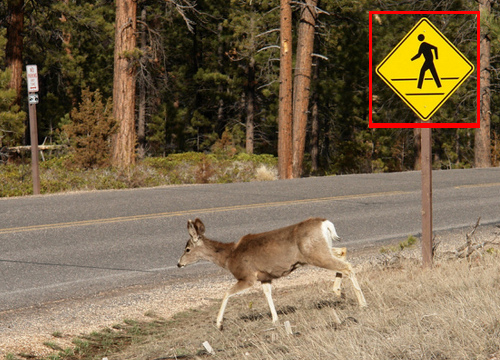

# Object Detection

In this assignment, you will develop an object detector based on gradient features and sliding window classification. A set of test images and ***hogvis.py*** are provided in the Canvas assignment directory

---

***Name:*** Shengyuan Lu

***SID:*** 93188958

---

In [458]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage as ski

np.set_printoptions(suppress=True) # supress scientific notation when printing numpy arrays

---
# 1. Image Gradients [20 pts]

Write a function that takes a grayscale image as input and returns two arrays the same size as the image,

the first of which contains the magnitude of the image gradient at each pixel

the second containing the orientation

Your function should filter the image with the simple x- and y-derivative filters described in class. Once you have the derivatives you can compute the orientation and magnitude of the gradient vector at each pixel. You should use  ***scipy.ndimage.correlate*** with the 'nearest' option in order to nicely handle the image boundaries.

Include a visualization of the output of your gradient calculate for a small test image. For displaying the orientation result, please uses a cyclic colormap such as "hsv" or "twilight".  (see https://matplotlib.org/tutorials/colors/colormaps.html)

NOTE: To be consistent with the provided code that follows, the gradient orientation values you return should range in (-pi/2,+pi/2) where a horizontal edge (vertical gradient) is -pi/2 and the angle increases as the edge rotates clockwise in the image.

In [466]:
def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    # convert the image to float
    if image.dtype == np.uint8:
        image = image.astype(float) / 256

    # convert the image to grayscale
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # blur the image
    image = ndimage.gaussian_filter(image, sigma=0.25)

    filter_x = np.array([[-1, 1]])
    filter_y = np.array([[-1], [1]])

    dx = ndimage.correlate(image, filter_x, mode='nearest')
    dy = ndimage.correlate(image, filter_y, mode='nearest')

    mag = np.sqrt(np.square(dx) + np.square(dy))
    ori = np.arctan(np.divide(dy, dx + 1.e-16))

    #ori = np.mod(orientation + np.pi/2, np.pi) - np.pi/2

    return mag, ori

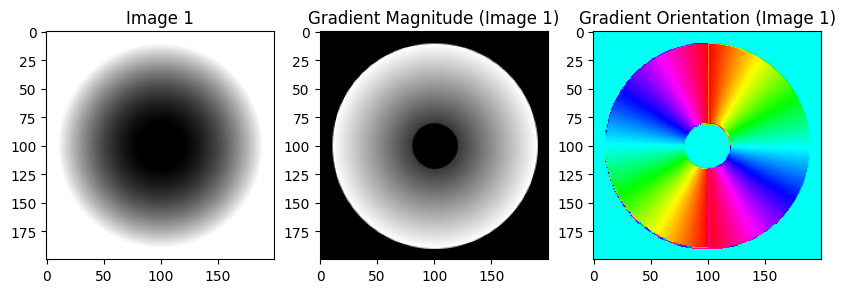

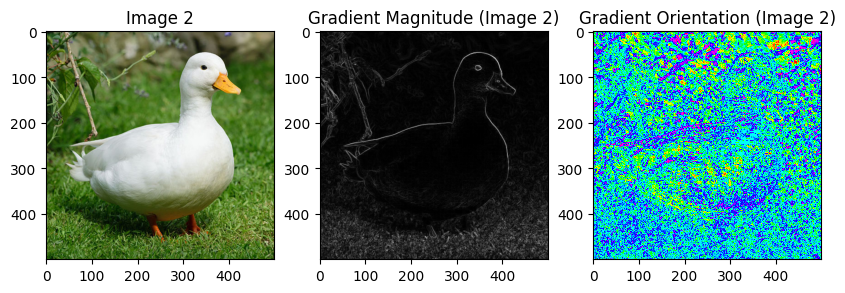

In [465]:
#
# Demonstrate your mygradient function here by loading in a grayscale
# image, calling mygradient, and visualizing the resulting magnitude
# and orientation images. For visualizing orientation image, I suggest 
# using the hsv or twilight colormap.
#

# Test Image
[yy,xx] = np.mgrid[-100:100, -100:100]
testimage = np.minimum(np.maximum(np.array(xx*xx+yy*yy,dtype=float),400),8100)

(mag, ori) = mygradient(testimage)

fig, axes = plt.subplots(1, 3, figsize=(10, 15))
axes[0].imshow(testimage, cmap=plt.cm.gray)
axes[0].set_title('Image 1')
axes[1].imshow(mag, cmap=plt.cm.gray)
axes[1].set_title('Gradient Magnitude (Image 1)')
axes[2].imshow(ori, cmap=plt.cm.hsv)
axes[2].set_title('Gradient Orientation (Image 1)')
plt.show()

# My Image
image = plt.imread('images/duck.jpg')

(mag, ori) = mygradient(image)

fig, axes = plt.subplots(1, 3, figsize=(10, 15))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Image 2')
axes[1].imshow(mag, cmap=plt.cm.gray)
axes[1].set_title('Gradient Magnitude (Image 2)')
axes[2].imshow(ori, cmap=plt.cm.hsv)
axes[2].set_title('Gradient Orientation (Image 2)')
plt.show()

---

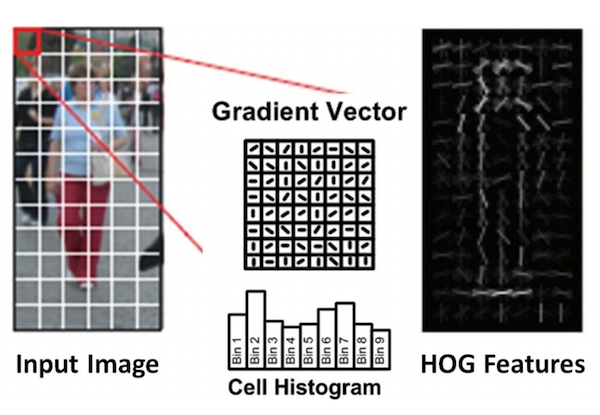

# 2. Histograms of Gradient Orientations [25 pts]

Write a function that computes gradient orientation histograms over each 8x8 block of pixels in an image.

Your function should bin the orientation into 9 equal sized bins between -pi/2 and pi/2. The input of your function will be an image of size HxW. The output should be a three-dimensional array ***ohist*** whose size is (H/8)x(W/8)x9 where ***ohist[i,j,k]*** contains the count of how many edges of orientation k fell in block (i,j). If the input image dimensions are not a multiple of 8, you should use ***np.pad*** with the ***mode=edge*** option to pad the width and height up to the nearest integer multiple of 8.

To determine if a pixel is an edge, we need to choose some threshold. I suggest using a threshold that is 10% of the maximum gradient magnitude in the image. Since each 8x8 block will contain a different number of edges, you should normalize the resulting histogram for each block to sum to 1 (i.e., ***np.sum(ohist,axis=2)*** should be 1 at every  location).

I would suggest your function loops over the orientation bins. For each orientation bin you'll need to identify those pixels in the image whose gradient magnitude is above the threshold and whose orientation falls in the given bin. You can do this easily in numpy using logical operations in order to generate an array the same size as the image that contains Trues at the locations of every edge pixel that falls in the given orientation bin and is above threshold. To collect up pixels in each 8x8 spatial block you can use the function ***ski.util.view_as_windows(...,(8,8),step=8)*** and ***np.count_nonzeros*** to count the number of edges in each block.

Test your code by creating a simple test image (e.g. a white disk on a black background), computing the descriptor and using the provided function ***hogvis*** to visualize it.

Note: in the discussion above I have assumed 8x8 block size and 9 orientations. In your code you should use the parameters ***bsize*** and ***norient*** in place of these constants.

In [469]:
def hog(image, bsize=8, norient=9):

    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.

    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values

    bsize : int
        The size of the spatial bins in pixels, defaults to 8

    norient : int
        The number of orientation histogram bins, defaults to 9

    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram

    """
    # determine the size of the HOG descriptor
    (h, w) = image.shape
    h2 = int(np.ceil(h / float(bsize)))
    w2 = int(np.ceil(w / float(bsize)))
    ohist = np.zeros((h2, w2, norient))

    # pad the input image on right and bottom as needed so that it
    # is a multiple of bsize
    pw = (0, int(w2 * bsize - w)) # amounts to pad on left and right side
    ph = (0, int(h2 * bsize - h)) # amounts to pad on bottom and top side
    image = np.pad(image, (ph, pw), 'edge')

    # make sure we did the padding correctly
    assert(image.shape == (h2 * bsize, w2 * bsize))

    # compute image gradients
    (mag, ori) = mygradient(image)

    # choose a threshold which is 10% of the maximum gradient magnitude in the image
    thresh = 0.1 * np.max(mag)

    # separate out pixels into orientation channels, dividing the range of orientations
    # [-pi/2,pi/2] into norient equal sized bins and count how many fall in each block
    # inEdges = np.linspace(-np.pi/2, np.pi/2, norient+1)

    left = -np.pi/2
    right = np.pi/9 -np.pi/2

    step = np.pi/norient

    # as a sanity check, make sure every pixel gets assigned to at most 1 bin.
    bincount = np.zeros((h2 * bsize, w2 * bsize))

    for i in range(norient):

        # create a binary image containing 1s for pixels at the ith
        # orientation where the magnitude is above the threshold.
        # B = np.zeros_like(ohist)
        B = (mag > thresh) * (ori <= right) * (ori >= left)

        #sanity check
        left += step
        right += step

        # sanity check: record which pixels have been selected at this orientation
        bincount += B

        # pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B, (bsize, bsize), step=bsize)

        # sum up the count for each block and store the results
        bcount = np.sum(chblock, axis=(2, 3))
        ohist[:, :, i] = bcount.reshape((h2, w2))

    # print(bincount.astype(int))

    assert(np.all(bincount<=1))

    # lastly, normalize the histogram so that the sum along the orientation dimension is 1

    # note: don't divide by 0! If there are no edges in a block (i.e. the sum of counts
    # is 0) then your code should leave all the values as zero.

    hist_sum = np.sum(ohist, axis=2)
    hist_sum[hist_sum < 1e-6] = 1
    ohist = np.divide(ohist, hist_sum[:, :, None])

    assert(ohist.shape==(h2, w2, norient))

    return ohist

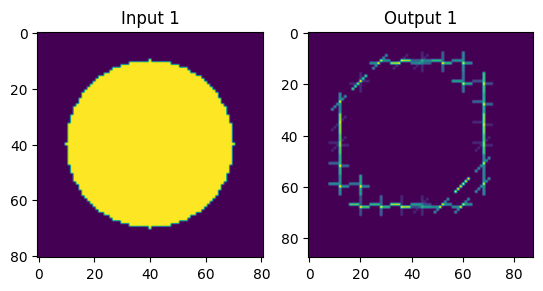

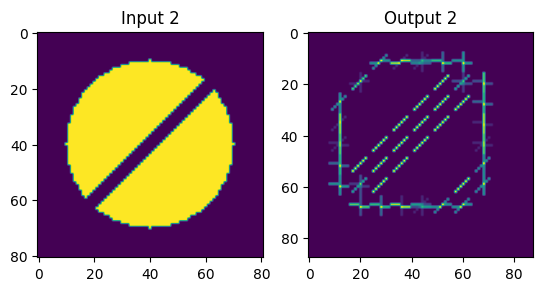

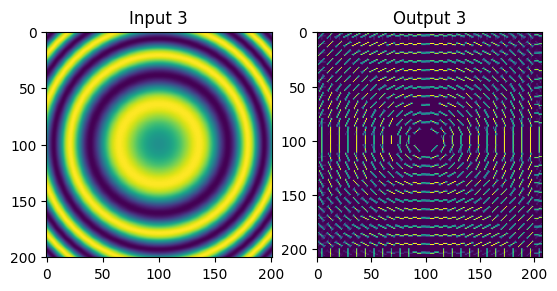

In [467]:
# provided function for visualizing hog descriptors
import hogvis as hogvis

# Test Image 1
[yy,xx] = np.mgrid[-40:41, -40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)

ohist = hog(im)
hogvis_result = hogvis.hogvis(ohist)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].set_title('Input 1')
axes[1].imshow(hogvis_result)
axes[1].set_title('Output 1')
plt.show()

# Test Image 2
[yy,xx] = np.mgrid[-40:41, -40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)
im[np.abs(xx+yy)<=3] = 0

ohist = hog(im)
hogvis_result = hogvis.hogvis(ohist)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].set_title('Input 2')
axes[1].imshow(hogvis_result)
axes[1].set_title('Output 2')
plt.show()

# Test Image 3
[yy,xx] = np.mgrid[-100:101, -100:101]
im = np.array(np.sin((xx*xx+yy*yy)/800),dtype=float)

ohist = hog(im)
hogvis_result = hogvis.hogvis(ohist)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].set_title('Input 3')
axes[1].imshow(hogvis_result)
axes[1].set_title('Output 3')
plt.show()

---
# 3. Detection [25 pts]

Write a function that takes a template and an image and returns the top detections found in the image. Your function should follow the definition given below.

In your function you should first compute the histogram-of-gradient-orientation feature map for the image, then correlate the template with the feature map. Since the feature map and template are both three dimensional, you will want to filter each orientation separately and then sum up the results to get the final response. If the image of size HxW then this final response map will be of size (H/8)x(W/8).

When constructing the list of top detections, your code should implement non-maxima suppression so that it doesn't return overlapping detections. You can do this by sorting the responses in descending order of their score. Every time you add a detection to the list to return, check to make sure that the location of this detection is not too close to any of the detections already in the output list. You can estimate the overlap by computing the distance between a pair of detections and checking that the distance is greater than say 70% of the width of the template.

Your code should return the locations of the detections in terms of the original image pixel coordinates (so if your detector had a high response at block [i,j] in the response map, then you should return (8*i,8*j) as the pixel coordinates).

I have provided a function for visualizing the resulting detections which you can use to test your detect function. Please include some visualization of a simple test case.

In [463]:
def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """   
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)
    
    
    #cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1])
    for i in range(norient):
        resp = resp + ndimage.correlate(...)
    
    #sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
    # 
    val = ...  #sorted response values
    ind = ...  #corresponding indices
    
    #work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []
    while ((detcount < ndetect) and (i < len(val))):
        # convert 1d index into 2d index
        yb = ...
        xb = ...
    
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        #covert block index to pixel coordinates based on bsize
        xp = ...
        yp = ...
    
        #check if this detection overlaps any detections that we've already added
        #to the list. compare the x,y coordinates of this detection to the x,y 
        #coordinates of the detections already in the list and see if any overlap
        #by checking if the distance between them is less than 70% of the template
        # width/height
    
        ...
        
        #if the detection doesn't overlap then add it to the list
        if not overlap:
            detcount = detcount + 1
            detections.append((xp,yp,val[i]))
        
        i=i+1
    
    if (len(detections) < ndetect):
        print('WARNING: unable to find ',ndetect,' non-overlapping detections')
        
    return detections

SyntaxError: '(' was never closed (530495825.py, line 39)

In [ ]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        
    plt.show()

In [ ]:
#
# sketch of some simple test code, modify as needed
#

#create a synthetic image with some overlapping circles
[yy,xx] = np.mgrid[-40:40,-80:80]
im1 = np.array((xx*xx+yy*yy<=30*30),dtype=float)
[yy,xx] = np.mgrid[-40:40,-40:120]
im2 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
[yy,xx] = np.mgrid[-40:40,-120:40]
im3 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
im = (1/3)*(im1+im2+im3)


#compute feature map with default parameters
fmap = hog(im)

#extract a 3x3 template
template = fmap[2:5,2:5,:]

#run the detect code
detections = detect(im,template,ndetect=5)
    
#visualize results. 
plot_detections(im,detections,(3*8,3*8))

# visually confirm that:
#   1. top detection should be the same as the location where we selected the template
#   2. multiple detections do not overlap too much

---
# 4. Learning Templates [15 pts]

The final step is to implement a function to learn a template from positive and negative examples. Your code should take a collection of cropped positive and negative examples of the object you are interested in detecting, extract the features for each, and generate a template by taking the average positive template minus the average negative template.



In [ ]:
def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    
    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    
    """           
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #figure to show positive training examples
    fig1 = plt.figure()
    pltct = 1

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in posfiles:
        #load in a cropped positive example
        img = ...

        #convert to grayscale and resize to fixed dimension tsize_pix
        #using skimage.transform.resize if needed.

        #display the example. if you want to train with a large # of examples, 
        #you may want to modify this, e.g. to show only the first 5.
        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        fmap = hog(...)

        #compute running average
        pos_t = ...

    pos_t = (1/len(posfiles))*pos_t
    fig1.show()
    
    # repeat same process for negative examples
    fig2 = plt.figure()
    pltct = 1  
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        ...
        ...
        ax = fig2.add_subplot(len(negfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        ...
        ...
        

    neg_t = (1/len(negfiles))*neg_t
    fig2.show()

    # add code here to visualize the positive and negative parts of the template
    # using hogvis. you should separately visualize pos_t and neg_t rather than
    # the final tempalte.
 

    # now construct our template as the average positive minus average negative
    template = pos_t - neg_t

    
    return template 


---
# 5. Experiments [15 pts]


Test your detection by training a template and running it on a test image.

In your experiments and writeup below you should include: (a) a visualization of the positive and negative patches you use to train the template and corresponding hog feature, (b) the detection results on the test image. You should show (a) and (b) for ***two different object categories***, the provided face test images and another category of your choosing (e.g. feel free to experiment with detecting cat faces, hands, cups, chairs or some other type of object).  Additionaly, please include results of testing your detector where there are at least 3 objects to detect (this could be either 3 test images which each have one or more objects, or a single image with many (more than 3) objects). Your test image(s) should be distinct from your training examples. Finally, write a brief (1 paragraph) discussion of where the detector works well and when it fails. Describe some ways you might be able to make it better.

NOTE 1: You will need to create the cropped test examples to pass to your ***learn_template***. You can do this by  cropping out the examples by hand (e.g. using an image editing tool). You should attempt to crop them out in the most consistent way possible, making sure that each example is centered with the same size and aspect ratio. Negative examples can be image patches that don't contain the object of interest. You should crop out negative examples with roughly the same resolution as the positive examples.

NOTE 2: For the best result, you will want to test on images where the object is the same size as your template. I recommend using the default ***bsize*** and ***norient*** parameters for all your experiments. You will likely want to modify the template size as needed


## Experiment 1: Face detection

In [ ]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')

# call learn_template to learn and visualize the template and training data
learn_template(posfiles,negfiles,tsize=tsize)
               
# call detect on one or more test images, visualizing the result with the plot_detections function

...
detections = detect(...)
plot_detections(im,detections,tsize_pix)


## Experiment 2: ??? detection